# Learnign Pair Potential from Experimental RDF data

## Importing stuff

In [1]:
import json
import os
from scipy import interpolate
from ase import units
from ase.visualize import *
from data_src.data import *
from potential_src.pairMLP.potential_PairMLP import *
from observables.rdf import *
from observables.observers import *   
from utils.get_utils import *
import matplotlib.pyplot as plt

MODEL_PATH = 'exp_rdf_model'
ID = 'run_0'
device = 'cpu'

## Some useful functions

In [2]:
def plot_rdfs(bins, target_g, simulated_g, fname, path, pname=None, save=True):
    plt.title("epoch {}".format(pname))
    plt.plot(bins, simulated_g.detach().cpu().numpy() , linewidth=4, alpha=0.6, label='sim.' )
    plt.plot(bins, target_g.detach().cpu().numpy(), linewidth=2,linestyle='--', c='black', label='exp.')
    plt.xlabel("$\AA$")
    plt.ylabel("g(r)")
    plt.savefig(path + '/{}.jpg'.format(fname), bbox_inches='tight')
    plt.show()
    plt.close()

    if save:
        data = np.vstack((bins, simulated_g.detach().cpu().numpy()))
        np.savetxt(path + '/{}.csv'.format(fname), data, delimiter=',')

def save_traj(system, traj, fname, skip=10):
    atoms_list = []
    for i, frame in enumerate(traj):
        if i % skip == 0: 
            frame = ase.Atoms(positions=frame, numbers=system.get_atomic_numbers())
            atoms_list.append(frame)
    ase.io.write(fname, atoms_list) 


def plot_pair(fn, path, model, prior, device, start=1.8, end=7.5, target_pot=None): 
    # Handle target_pot (add default or move to CPU if provided)
    if target_pot is None:
        target_pot = LennardJones(1.0, 1.0)
    else:
        target_pot = target_pot.to("cpu")

    # Sample input range with specified resolution
    x = torch.linspace(start, end, 1000)[:, None].to(device)
    
    # Compute fitted potential (u_fit)
    u_fit = (model(x) + prior(x)).detach().cpu().numpy()
    u_fit = u_fit - u_fit[-1] 



    # Plot u_fit and u_target
    plt.plot( x.detach().cpu().numpy(), 
              u_fit, 
              label='fit', linewidth=4, alpha=0.6)
    
    plt.plot( x,target_pot,
              label='truth', 
              linewidth=2, linestyle='--', c='black')

    # Set y-axis limits for consistent visualization
    plt.ylim(-1, 1.0)
    plt.xlim(1.8,7)
    plt.legend()      
    plt.show()

    # Save plot to specified path
    plt.savefig(path + '/potential_{}.jpg'.format(fn), bbox_inches='tight')
    plt.close()

    return u_fit

def make_folder(project_name, suggestion_id):
    """
    Creates a folder structure for the given project and suggestion ID.
    Only creates the folder if it does not already exist.
    """
    MODEL_PATH = '{}/{}'.format(project_name, suggestion_id)
    if not os.path.exists(MODEL_PATH):  # Check if the folder exists
        os.makedirs(MODEL_PATH)  # Create the folder if it doesn't exist
    return MODEL_PATH


## Parameters Setting

In [3]:

assignments = {
        "anneal_freq": 7,
        "anneal_rate": 5.2,
        "cutoff": 4.9,
        "epsilon": 1,
        "gaussian_width": 0.145,
        "n_width": 128,
        "n_layers": 3,
        "lr": 0.000025,
        "mse_weight": 0.4,
        "n_atom_basis": "high",
        "n_convolutions": 3,
        "n_filters": "mid",
        "nbins": 90,
        "opt_freq": 26,
        "sigma": 1.9,
        "start_T": 200,
        "nonlinear": "ReLU",
        "power": 12,
    }

sys_params = {
        'dt': 1.0,
        'n_epochs': 500,
        'n_sim': 10,
        'data': "H20_0.997_298K", #'Si_2.293_100K',
        'val': None,
        'size': 4,
        'anneal_flag': True,
        'pair_flag': True,
    }

config = load_config()
# here are some dictionaries with datas properties
exp_rdf_data_dict = config.get("exp_rdf_data_dict", {})
DATA_TAG = "H20_0.997_298K"  
vals = []

We've called DATA_TAG = "H20_0.997_298K". Looking inside config.json: 

<img src="images/Screenshot 2025-01-29 alle 17.38.53.png" alt="Simulation" width="300">

Let's define the system class:

In [4]:
config = load_config()
DATA_TAG =   "H20_0.997_298K"   #"Si_2.293_100K"  # Change this to a data tag from config.json
size = sys_params['size']  # System size for visualization
# Check if the data tag exists in the configuration
if DATA_TAG not in config["exp_rdf_data_dict"]:
    print(f"Data tag '{DATA_TAG}' not found in config.")
    sys.exit(1)  # Exit the script with an error code


# Run visualization
print(f"Visualizing system for data tag '{DATA_TAG}'...")
visualize_system_with_ase_3d(DATA_TAG, size)
print("Visualization completed.")

Visualizing system for data tag 'H20_0.997_298K'...
Visualization completed.


In [5]:
make_folder(MODEL_PATH, ID)

'exp_rdf_model/run_0'

In [6]:
train_list = [DATA_TAG]
val_list = []
for val in vals:
    val_list.append(val)

all_sys = []
if len(val_list)>0:
    all_sys = train_list + val_list
else:
    all_sys = train_list

In [7]:
system_list = []
for data_tag in all_sys:
    if data_tag not in exp_rdf_data_dict:
        raise KeyError(f"Data tag '{data_tag}' not found in exp_rdf_data_dict.")
    #print('data tag: ',data_tag) #H20_0.997_298K
    system = get_system(data_tag, device, sys_params['size']) 
    if sys_params['anneal_flag'] == 'True': # set temp 
        system.set_temperature(assignments['start_T'] * units.kB)
    system_list.append(system)


Data tag: H20_0.997_298K
Lattice param: 6.215 Å


/Users/francescapagano/miniconda3/envs/myenv_mlmd/lib/python3.9/site-packages/ase/md/md.py:52: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


system is an Atoms class from ASE. We can have a look at it:

In [8]:
from ase.visualize import view
view(system_list[0])

<Popen: returncode: None args: ['/Users/francescapagano/miniconda3/envs/myen...>

## Pair Potential 

In [9]:
def get_pair_potential(assignments, sys_params):
    cutoff = assignments['cutoff']
    mlp_parmas = {'n_gauss': int(cutoff//assignments['gaussian_width']), 
              'r_start': 0.0,
              'r_end': cutoff, 
              'n_width': assignments['n_width'],
              'n_layers': assignments['n_layers'],
              'nonlinear': assignments['nonlinear'],
              'res': False}

    lj_params = {'epsilon': assignments['epsilon'], 
         'sigma': assignments['sigma'],
       }
    net = pairMLP(**mlp_parmas)
    #net = pairTab(rc=10.0, device=sys_params['device'])
    prior = LennardJones(**lj_params)
    return net, prior

net, prior = get_pair_potential(assignments, sys_params)
net = net.to(device)
prior = prior.to(device)

### Pre-Training

here we add to all_pot the potential found from the theoretical relation  
$$
 U = - k_B * T * log(g(r))
$$
g is the observed one. 
This is obtained using 'get_exp_rdf'.

In [10]:
def get_observer(system, data_tag, nbins):
    data_path = exp_rdf_data_dict[data_tag]['fn']
    data = np.loadtxt(data_path, delimiter=',')

    # define the equation of motion to propagate 
    start = exp_rdf_data_dict[data_tag]['start']
    end = exp_rdf_data_dict[data_tag]['end']

    xnew = np.linspace(start, end, nbins)
    obs = rdf(system, nbins, (start, end))
    # get experimental rdf 

    count_obs, g_obs = get_exp_rdf(data, nbins, (start, end), obs.device)
    # initialize observable function 
    return xnew, g_obs, obs


In [11]:
all_pot = []
for i, data_tag in enumerate(all_sys):
    x, g_obs, obs = get_observer(system_list[i], data_tag, assignments['nbins'])
    print('x, g_obs, g: ', x, g_obs, obs )
    T = exp_rdf_data_dict[data_tag]['T']
    pot = - units.kB * T * torch.log(g_obs)
    all_pot.append(pot)

x, g_obs, g:  [1.8        1.86404494 1.92808989 1.99213483 2.05617978 2.12022472
 2.18426966 2.24831461 2.31235955 2.37640449 2.44044944 2.50449438
 2.56853933 2.63258427 2.69662921 2.76067416 2.8247191  2.88876404
 2.95280899 3.01685393 3.08089888 3.14494382 3.20898876 3.27303371
 3.33707865 3.4011236  3.46516854 3.52921348 3.59325843 3.65730337
 3.72134831 3.78539326 3.8494382  3.91348315 3.97752809 4.04157303
 4.10561798 4.16966292 4.23370787 4.29775281 4.36179775 4.4258427
 4.48988764 4.55393258 4.61797753 4.68202247 4.74606742 4.81011236
 4.8741573  4.93820225 5.00224719 5.06629213 5.13033708 5.19438202
 5.25842697 5.32247191 5.38651685 5.4505618  5.51460674 5.57865169
 5.64269663 5.70674157 5.77078652 5.83483146 5.8988764  5.96292135
 6.02696629 6.09101124 6.15505618 6.21910112 6.28314607 6.34719101
 6.41123596 6.4752809  6.53932584 6.60337079 6.66741573 6.73146067
 6.79550562 6.85955056 6.92359551 6.98764045 7.05168539 7.11573034
 7.17977528 7.24382022 7.30786517 7.37191011 7.43

/Users/francescapagano/mdgrad_mini/srcLJ/observables/rdf.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  self.cell = torch.Tensor( system.get_cell()).diag().to(self.device)


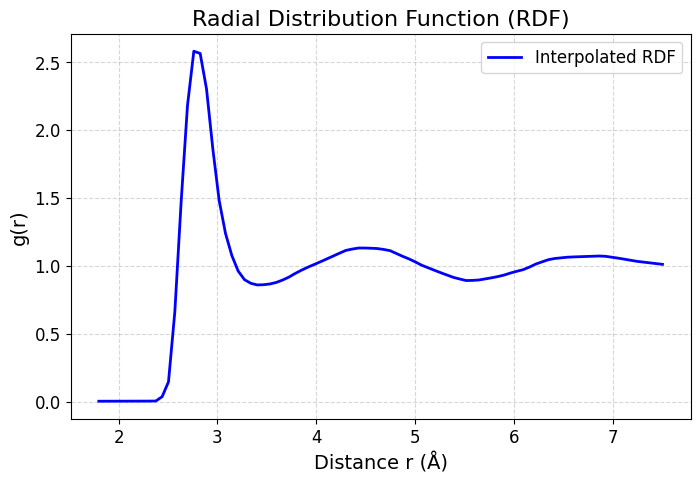

In [12]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(8, 5))

# Plot RDF
plt.plot(x, g_obs.cpu().numpy(), label="Interpolated RDF", color='b', linewidth=2, linestyle="-")

# Labels & Titles
plt.xlabel("Distance r (Å)", fontsize=14)
plt.ylabel("g(r)", fontsize=14)
plt.title("Radial Distribution Function (RDF)", fontsize=16)

# Grid & Aesthetics
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save and Show
plt.savefig("rdf_plot.png", dpi=300, bbox_inches="tight")  # Save as high-resolution PNG
plt.show()


In [13]:
bi = torch.stack(all_pot).mean(0)
bi = torch.nan_to_num(bi,  posinf=100.0)

f = interpolate.interp1d(x, bi.detach().cpu().numpy())
rrange = np.linspace(2.5, 7.5, 1000)
u_target = f(rrange)

u_target = torch.Tensor(u_target).to(device)
rrange = torch.Tensor(rrange).to(device)

optimizer = torch.optim.Adam(list(net.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                            'min', 
                                            min_lr=0.9e-7, 
                                            verbose=True, factor = 0.5, patience=25,
                                            threshold=1e-5)

/Users/francescapagano/miniconda3/envs/myenv_mlmd/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
for i in range(4000):
    u_fit = net(rrange.unsqueeze(-1)) + prior(rrange.unsqueeze(-1))
    loss = (u_fit.squeeze() - u_target).pow(2).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    scheduler.step(loss.item())

    if i % 50 == 0:
        print(i, loss.item())

np.savetxt(MODEL_PATH + f'/bi.txt', u_target.detach().cpu().numpy())
np.savetxt(MODEL_PATH + f'/fit.txt', u_fit.detach().cpu().numpy())
print('esco')


0 0.023630201816558838


50 0.0013873039279133081
100 9.014079296321142e-06
150 1.2153720490459818e-05
200 5.167552899365546e-06
250 4.860372428083792e-06
300 4.570400960801635e-06
350 4.268151769792894e-06
400 3.943788215110544e-06
450 3.5990819924336392e-06
500 3.2344250939786434e-06
550 2.8556269171531312e-06
600 2.458298467900022e-06
650 2.1029920844739536e-06
700 2.3303045963984914e-06
750 1.5840272453715443e-06
800 1.431537725693488e-06
850 1.2979262464796193e-06
900 1.1735959333236679e-06
950 1.0575129181233933e-06
1000 9.50737216953712e-07
1050 8.531214916729368e-07
1100 7.646357289559091e-07
1150 6.848406428616727e-07
1200 6.13053202869196e-07
1250 5.483611289491819e-07
1300 4.907532229481149e-07
1350 4.399837507662596e-07
1400 3.952044949073752e-07
1450 3.5582229429564904e-07
1500 3.211908392586338e-07
1550 2.9067328455312236e-07
1600 2.636573981362744e-07
1650 2.3973652218955976e-07
1700 2.1854043552593794e-07
1750 1.9960653219186497e-07
1800 4.998638360120822e-06
1850 1.766902784083868e-07
1900 1.6

In [15]:
sim_list = build_simulators(all_sys, system_list, net, prior, 
                            cutoff=assignments['cutoff'], pair_flag=sys_params["pair_flag"],
                            tpair_flag=False,
                            topology_update_freq=1)

g_target_list = []
obs_list = []
bins_list = []
for i, data_tag in enumerate(all_sys):
    x, g_obs, obs = get_observer(system_list[i], data_tag, assignments['nbins'])
    bins_list.append(x)
    g_target_list.append(g_obs)
    obs_list.append(obs)
#plt.plot(x,g_obs)
#plt.plot(x,obs)
#plt.title('g_obs')
#plt.show()
# define optimizer 
optimizer = torch.optim.Adam(list(net.parameters()), lr=assignments['lr'])

loss_log = []

solver_method = 'verlet'
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                'min', 
                                                min_lr=0.9e-7, 
                                                verbose=True, factor = 0.5, patience=25,
                                                threshold=1e-5)


KeyError: 'H20_0.997_298K'

## Training

here


/var/folders/dx/b9tk_hhd1x1dxjmtzwfq_p6w0000gn/T/ipykernel_90799/2433928617.py:40: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  rho = system_list[j].get_number_of_atoms() / system_list[j].get_volume()


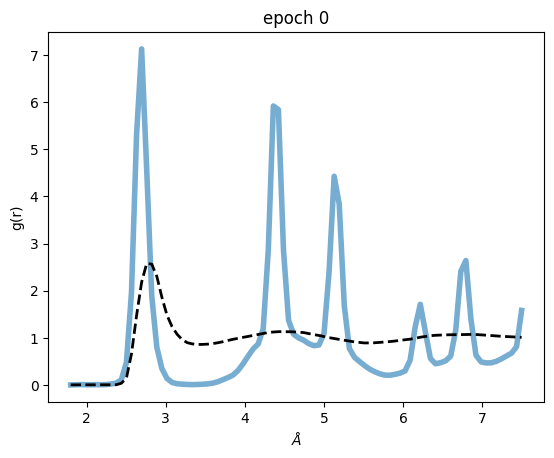

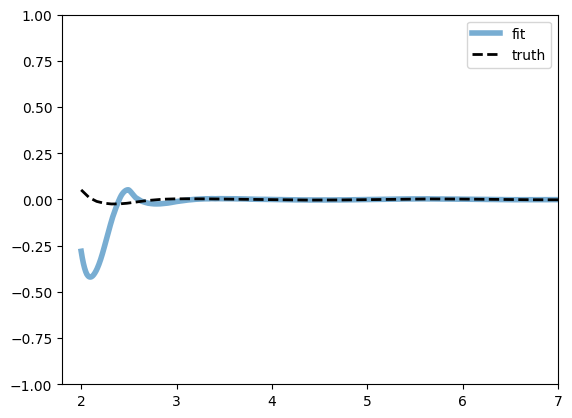

epoch 0 | loss: 71.37997
here


/var/folders/dx/b9tk_hhd1x1dxjmtzwfq_p6w0000gn/T/ipykernel_90799/2433928617.py:40: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  rho = system_list[j].get_number_of_atoms() / system_list[j].get_volume()


epoch 1 | loss: 4.40674
here
epoch 2 | loss: 0.88972
here
epoch 3 | loss: 0.40589
here
epoch 4 | loss: 0.57034
here
epoch 5 | loss: 0.60787
here
epoch 6 | loss: 0.68985
here
epoch 7 | loss: 0.82969
here
epoch 8 | loss: 0.80736
here
epoch 9 | loss: 0.62732
here


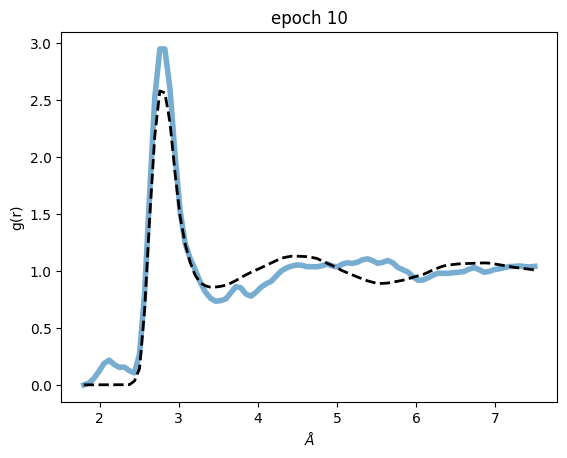

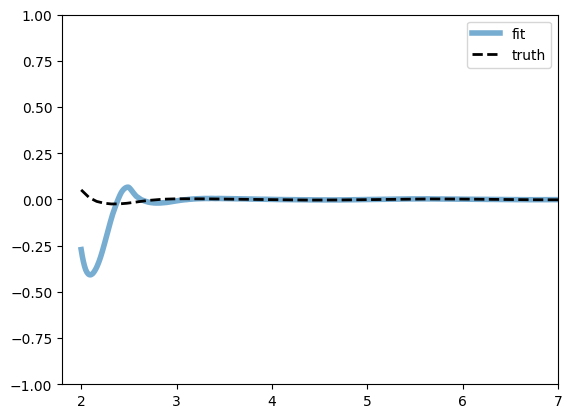

epoch 10 | loss: 0.61254
here


/var/folders/dx/b9tk_hhd1x1dxjmtzwfq_p6w0000gn/T/ipykernel_90799/2433928617.py:40: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  rho = system_list[j].get_number_of_atoms() / system_list[j].get_volume()


epoch 11 | loss: 0.64976
here
epoch 12 | loss: 0.58332
here
epoch 13 | loss: 0.67764
here
epoch 14 | loss: 0.81242
here
epoch 15 | loss: 0.95985
here
epoch 16 | loss: 0.92311
here
epoch 17 | loss: 1.00877
here
epoch 18 | loss: 0.86091
here
epoch 19 | loss: 0.72582
here


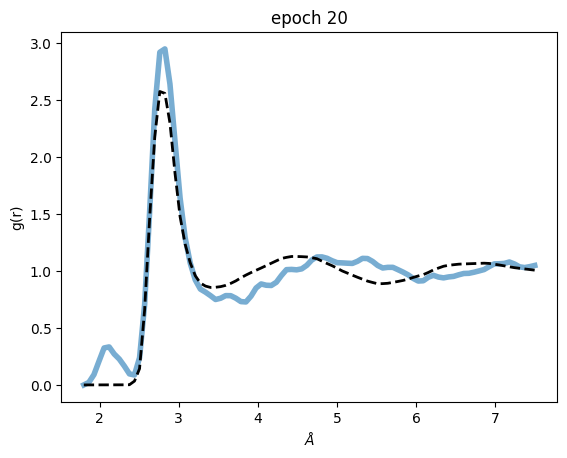

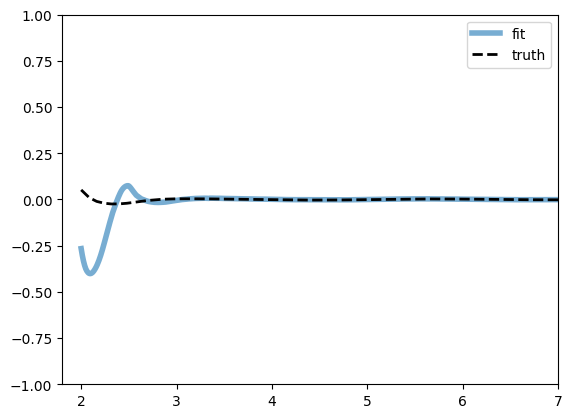

epoch 20 | loss: 0.67248
here


/var/folders/dx/b9tk_hhd1x1dxjmtzwfq_p6w0000gn/T/ipykernel_90799/2433928617.py:40: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  rho = system_list[j].get_number_of_atoms() / system_list[j].get_volume()


epoch 21 | loss: 0.65037
here
epoch 22 | loss: 0.50333
here
epoch 23 | loss: 0.42115
here
epoch 24 | loss: 0.47682
here
epoch 25 | loss: 0.52113
here
epoch 26 | loss: 0.43245
here
epoch 27 | loss: 0.54482
here
epoch 28 | loss: 0.53213
here
epoch 29 | loss: 0.52389
here


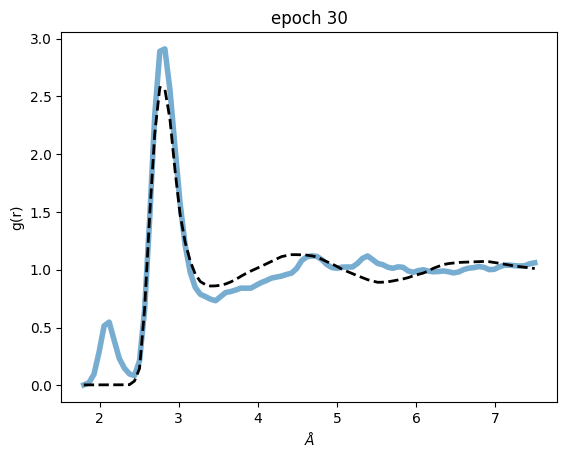

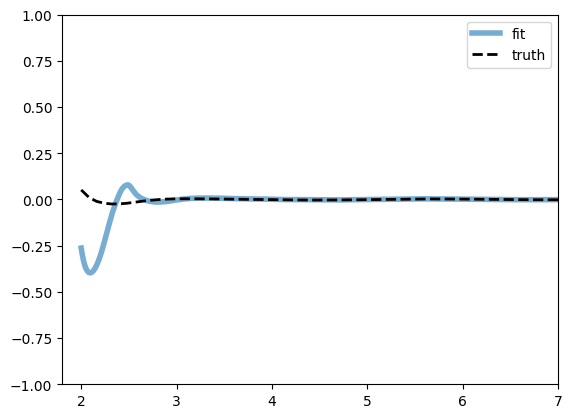

epoch 30 | loss: 0.58256
here


/var/folders/dx/b9tk_hhd1x1dxjmtzwfq_p6w0000gn/T/ipykernel_90799/2433928617.py:40: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  rho = system_list[j].get_number_of_atoms() / system_list[j].get_volume()


epoch 31 | loss: 0.58039
here
epoch 32 | loss: 0.48106
here
epoch 33 | loss: 0.60334
here
epoch 34 | loss: 0.60725
here
epoch 35 | loss: 0.59087
here
epoch 36 | loss: 0.52983
here
epoch 37 | loss: 0.52036
here
epoch 38 | loss: 0.54576
here
epoch 39 | loss: 0.52295
here


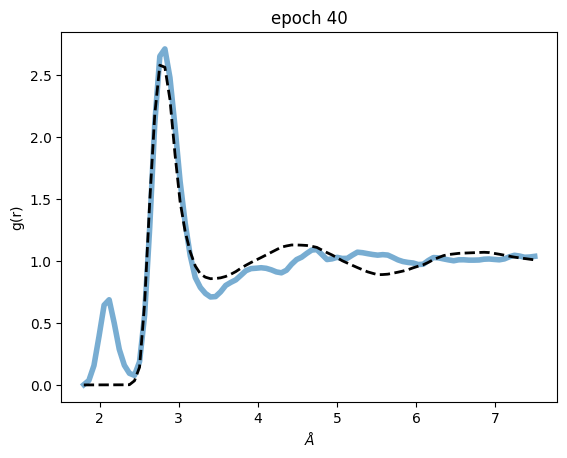

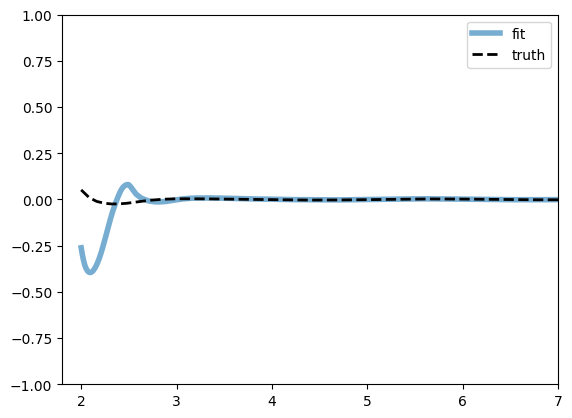

epoch 40 | loss: 0.56208
here


/var/folders/dx/b9tk_hhd1x1dxjmtzwfq_p6w0000gn/T/ipykernel_90799/2433928617.py:40: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  rho = system_list[j].get_number_of_atoms() / system_list[j].get_volume()


epoch 41 | loss: 0.59584
here
epoch 42 | loss: 0.63797
here
epoch 43 | loss: 0.59320
here
epoch 44 | loss: 0.60898
here
epoch 45 | loss: 0.56743
here
epoch 46 | loss: 0.55155
here
epoch 47 | loss: 0.60021
here
epoch 48 | loss: 0.70593
here
epoch 49 | loss: 0.65483
here


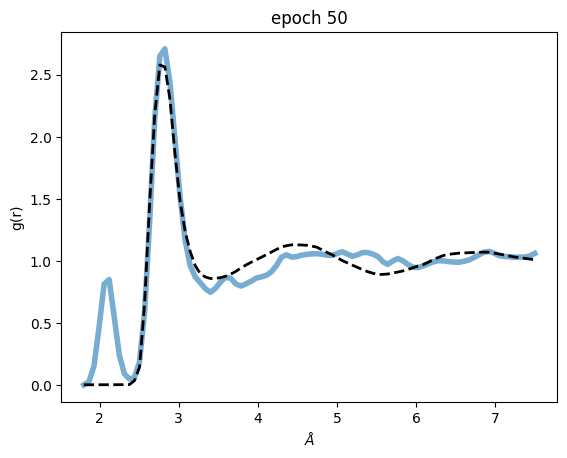

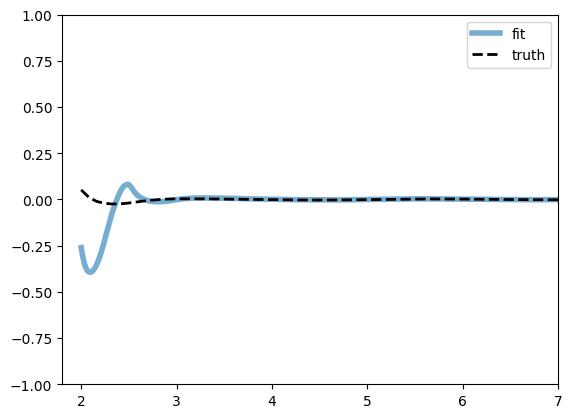

epoch 50 | loss: 0.54455
here


/var/folders/dx/b9tk_hhd1x1dxjmtzwfq_p6w0000gn/T/ipykernel_90799/2433928617.py:40: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  rho = system_list[j].get_number_of_atoms() / system_list[j].get_volume()


epoch 51 | loss: 0.57927
here
epoch 52 | loss: 0.65249
here
epoch 53 | loss: 0.58792
here
epoch 54 | loss: 0.54160
here
epoch 55 | loss: 0.58019
training converged


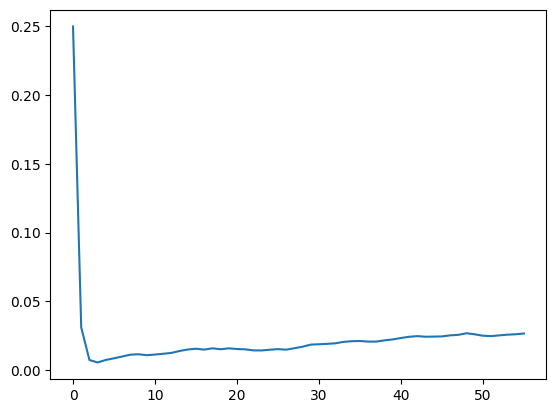

In [16]:
for i in range(0, sys_params['n_epochs'] ):
    print('here')    

    loss_js = torch.Tensor([0.0]).to(device)
    loss_mse = torch.Tensor([0.0]).to(device)

    # temperature annealing 
    for j, sim in enumerate(sim_list[:len(train_list)]):

        data_tag = all_sys[j]

        if sys_params['anneal_flag'] == 'True' and i % assignments['anneal_freq'] == 0:

            T_equil = exp_rdf_data_dict[data_tag]['T']
            T_start = assignments['start_T']
            new_T  = get_temp(T_start, T_equil, sys_params['n_epochs'] , i, assignments['anneal_rate'])
            sim.integrator.update_T(new_T * units.kB)

            print("update T: {:.2f}".format(new_T))

        v_t, q_t, pv_t = sim.simulate(steps=assignments['opt_freq'] , frequency=int(assignments['opt_freq'] ))

        if torch.isnan(q_t.reshape(-1)).sum().item() > 0:
            print( 5 - (i / sys_params['n_epochs'] ) * 5 )
            break 

        _, bins, g = obs_list[j](q_t[::20])
    
    #---------------------------------------------------------------------
        # only optimize on data that needs training 
        if data_tag in train_list:

            def compute_D(dev, rho, rrange):
                return (4 * np.pi * rho * (rrange ** 2) * dev ** 2 * (rrange[2]- rrange[1])).sum()

            loss_js += JS_rdf(g_target_list[j], g)
            #loss_mse += assignments['mse_weight'] * (g - g_target_list[j]).pow(2).mean() 

            rrange = torch.linspace(bins[0], bins[-1], g.shape[0])
            rho = system_list[j].get_number_of_atoms() / system_list[j].get_volume()

            loss_mse += compute_D(g - g_target_list[j], rho, rrange.to(device))

        if i % 10 == 0:
            plot_rdfs(bins_list[j], g_target_list[j], g, "{}_{}".format(data_tag, i),
                            MODEL_PATH, pname=i)

            if sys_params['pair_flag']:
                potential = plot_pair( path=MODEL_PATH,
                                fn=str(i),
                                model=net, 
                                prior=prior, 
                                device=device,
                                start=2, end=8,
                                target_pot=u_target)

                np.savetxt(MODEL_PATH + '/potential.txt', potential)

    #--------------------------------------------------------------------------------

    loss = loss_mse 
    loss.backward()
    
    print("epoch {} | loss: {:.5f}".format(i, loss.item()) ) 
    
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss)

    loss_log.append(loss_js.item() )

    if optimizer.param_groups[0]["lr"] <= 1.0e-5:
        print("training converged")
        break

plt.plot(loss_log)
plt.savefig(MODEL_PATH + '/loss.jpg', bbox_inches='tight')



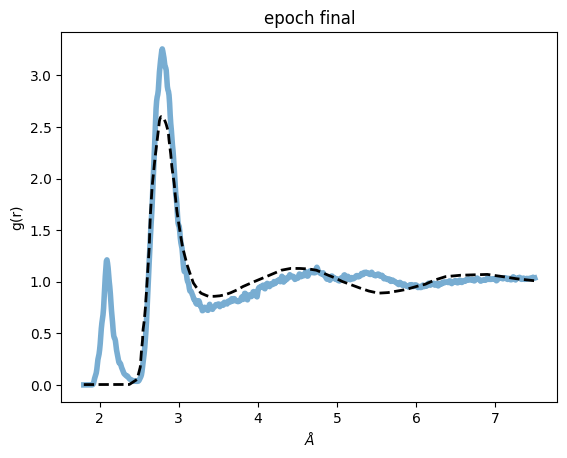

In [17]:

total_loss = 0.
rdf_devs = []
for j, sim in enumerate(sim_list):    
    data_tag = all_sys[j]

    train_traj = sim.log['positions']

    if all_sys[j] in train_list:
        save_traj(system_list[j], train_traj, MODEL_PATH + '/{}_train.xyz'.format(data_tag), skip=10)
    else:
        save_traj(system_list[j], train_traj, MODEL_PATH + '/{}_val.xyz'.format(data_tag), skip=10)

    # Inference 

    for i in range(sys_params['n_sim'] ):
        _, q_t, _ = sim.simulate(steps=100, frequency=25)
        
    trajs = torch.Tensor( np.stack( sim.log['positions'])).to(system.device)

    test_nbins = 800
    x, g_obs, obs = get_observer(system_list[j], data_tag, test_nbins)

    all_g_sim = []
    for i in range(len(trajs)):
        _, _, g_sim = obs(trajs[[i]])
        all_g_sim.append(g_sim.detach().cpu().numpy())

    all_g_sim = np.array(all_g_sim).mean(0)

    # compute equilibrated rdf 
    loss_js = JS_rdf(g_obs, torch.Tensor(all_g_sim).to(device))

    loss_mse = (g_obs - torch.Tensor(all_g_sim).to(device)).pow(2).mean()

    if data_tag in train_list:
        rdf_devs.append( (g_obs - torch.Tensor(all_g_sim).to(device)).abs().mean().item())

    save_traj(system_list[j], np.stack( sim.log['positions']),  
        MODEL_PATH + '/{}_sim.xyz'.format(data_tag), skip=1)

    plot_rdfs(x, g_obs, torch.Tensor(all_g_sim), "{}_final".format(data_tag), MODEL_PATH, pname='final')

    total_loss += loss_mse.item()

np.savetxt(MODEL_PATH + '/loss.csv', np.array(loss_log))
np.savetxt(MODEL_PATH + '/rdf_mse.txt', np.array(rdf_devs))
